![](images/2025-09-04-mobilenetv2-spiral-experiment.jpeg)

## Introduction

I was recently re-reading a paper that I consider a classic in the world of efficient AI: Google's [**"MobileNetV2: Inverted Residuals and Linear Bottlenecks."**](https://arxiv.org/abs/1801.04381) It's a cornerstone of modern computer vision, and its ideas power countless applications running on our phones every day.

As I was going through its theoretical section, I was struck again by a fascinating and somewhat puzzling claim. The authors argue that a fundamental building block of virtually all modern neural networks, the ReLU activation function, can be surprisingly destructive. It can take the rich, structured information a network has learned and literally wipe parts of it out of existence.

But then they proposed a clever trick to prevent this. They claimed that if you first take your data and project it into a *much higher-dimensional space*, you create a kind of "safety net." In this expanded space, ReLU can perform its magic without causing catastrophic damage.

![Experiment results from the original paper](images/2025-09-04-mobilenetv2-spiral-experiment/paper-figure-1.PNG){.lightbox}

This sounded incredibly cool, but also very abstract. What does it even mean to project a spiral into a 30-dimensional space? Can you actually *see* this "information destruction" and subsequent "information preservation" happen?

I decided to put it to the test. In this post, we're going to recreate the paper's beautiful spiral experiment from scratch.

::: {.callout-tip title="Get the code" collapse="false"}

All the code can be found in the GitHub repository : [2025-09-04-mobilenetv2-spiral-experiment.ipynb](https://github.com/hassaanbinaslam/hassaanbinaslam.github.io/tree/main/posts/2025-09-04-mobilenetv2-spiral-experiment.ipynb).

:::

## The Experiment: How to Simulate a Neural Network Layer

Before we jump into the code, let's lay out our game plan. We're trying to simulate the journey of a feature map, what the paper calls a "manifold of interest", as it passes through a single, simplified neural network layer. Our simulation will have three key stages that directly mirror the paper's theory.

### Step 1: Our "Manifold of Interest" - The Spiral

First, we need some data. In a real network, the "manifold of interest" is a complex, high-dimensional shape representing learned features like edges, textures, or even parts of a face. That's a bit hard to draw.

Instead, we'll use a simple 2D spiral as a stand-in. It's a perfect choice because it has a clear, recognizable structure. If any part of our transformation process damages the spiral, we'll be able to see it instantly.

### Step 2: The Transformation Pipeline

Next, we'll pass our spiral through a three-step pipeline designed to mimic the MobileNetV2 block:

1.  **Expand (Project Up):** We'll take our 2D spiral and project it into a higher, `n`-dimensional space. This `n` is the key variable we'll be changing. We'll test small values (like `n=2` or `n=3`) and large values (like `n=15` or `n=30`). This step simulates the "expansion" layer of the network.

2.  **Apply Non-linearity (The Dangerous Part):** While the data is living in this high-dimensional space, we'll apply the `ReLU` function to it. This is the moment of truth. According to the theory, this step is potentially destructive.

3.  **Project Back (Observe the Result):** We can't see what's happening in 30 dimensions, so to check on our spiral, we need to bring it back home. We'll project the data from the `n`-dimensional space back down to 2D so we can plot it and see what happened.

By comparing the final plot to our original input spiral, we can visually determine whether the information was preserved or destroyed.

## The Code: Bringing the Theory to Life with Python

Alright, let's translate our experiment into code. We'll be using two of the most common libraries in data science: `numpy` for the heavy lifting with matrix math, and `matplotlib` to visualize our results.

### Part 1: Generating the Spiral

First, we need a function to create our hero — the 2D spiral. We can do this easily using some basic trigonometry. This function generates a set of (x, y) coordinates that trace out a nice, clean spiral.

In [27]:
import numpy as np

def generate_spiral(num_points=1000, revolutions=3):
    """
    Generates a 2D spiral dataset using polar coordinates.
    """
    # STEP 1: Define the ANGLE (theta)
    # We want to sweep around a circle multiple times. A full circle is 2*pi radians.
    # To go around, say, 3 times, we need our angle to go from 0 to 3 * 2 * pi.
    # np.linspace gives us an array of evenly spaced numbers in that range.
    # So, `theta` is now an array of 1000 angles, from 0 up to our max angle.
    theta = np.linspace(0, revolutions * 2 * np.pi, num_points)
    
    # STEP 2: Define the RADIUS (r)
    # For a circle, the radius is constant. For a spiral, we want the radius
    # to grow as the angle gets bigger. The simplest way to do this is to just
    # set the radius equal to the angle! As `theta` increases, `radius` increases too.
    radius = theta
    
    # STEP 3: Convert from Polar to Cartesian Coordinates
    # We now have 1000 points defined by their polar coordinates (radius, theta).
    # To plot them on a standard graph, we need to convert them to (x, y) coordinates.
    # The standard conversion formulas are:
    # x = r * cos(theta)
    # y = r * sin(theta)
    # Since `radius` and `theta` are numpy arrays, this calculation happens for
    # all 1000 points at once in an efficient, "vectorized" way.
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    
    # STEP 4: Combine into a single array
    # We now have two separate arrays, `x` and `y`, each with 1000 numbers.
    # We want to combine them into a single structure for easier handling.
    # np.vstack stacks them vertically into a (2, 1000) array.
    # The .T (transpose) operation flips this to a (1000, 2) array.
    # Now, each row of our final array is a single (x, y) point on the spiral.
    spiral_data = np.vstack((x, y)).T
    return spiral_data

Running just the `generate_spiral` function and plotting its output gives us our beautiful starting manifold. This is the "perfect" information we are trying to preserve. It's the benchmark against which we'll measure the success or failure of our transformation.

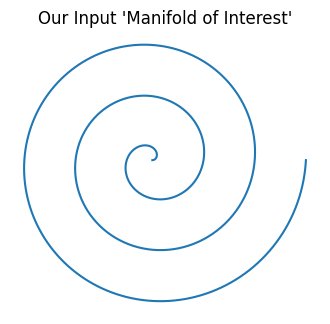

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the spiral
input_spiral = generate_spiral()

# Plot it
plt.figure(figsize=(4, 4))
plt.plot(input_spiral[:, 0], input_spiral[:, 1])
plt.title("Our Input 'Manifold of Interest'")
plt.gca().set_aspect('equal', 'box')
plt.axis('off')
plt.show()

Our entire goal is to see if it survives the journey through our simulated network layer. Now, let's build the pipeline that will put it to the test.

### Part 2: The Transformation Function

This next function is the core of our entire experiment. It takes our 2D spiral, sends it on its journey through high-dimensional space, and brings it back.

I'll show you the final, working code first, and then I'll confess a little bug I ran into along the way. It's a great example of the kind of thing you run into when working with linear algebra.

In [29]:
def transform_manifold(data_2d, n_dim):
    """
    Projects 2D data to n_dim, applies ReLU, and projects back.
    """
    # Let's trace the shapes with data_2d.shape = (1000, 2) and n_dim = 15

    # --- STEP 1: Create the "Expansion" Matrix ---
    # We need a matrix that can transform a 2D vector into a 15D vector.
    # To do this, it must have a shape of (2, 15).
    # np.random.randn fills this matrix with random numbers from a
    # standard normal distribution. This simulates the random initial
    # weights of a new neural network layer.
    T_forward = np.random.randn(2, n_dim)
    # T_forward.shape is (2, 15)

    # --- STEP 2: Project Up to High-Dimensional Space ---
    # This is the "Expand" operation. We use the matrix multiplication
    # operator (@) to apply the transformation.
    # The shapes must be compatible: (1000, 2) @ (2, 15) -> (1000, 15)
    # The inner dimensions (2 and 2) match, which is perfect.
    # The result, `projected_data`, is our spiral, but now each of its
    # 1000 points is represented by 15 numbers instead of 2.
    projected_data = data_2d @ T_forward
    # projected_data.shape is (1000, 15)
    
    # --- STEP 3: Apply the ReLU Non-Linearity ---
    # `np.maximum(0, array)` is the numpy equivalent of the ReLU function.
    # It scans through every single number in our (1000, 15) matrix and
    # replaces any negative number with a zero.
    # This is the critical, information-destroying step.
    relu_data = np.maximum(0, projected_data)
    # relu_data.shape is still (1000, 15)
    
    # --- STEP 4: Create the "Projection Back" Matrix ---
    # Now we need to get back to 2D so we can see what happened.
    # We can't use a true inverse because our `T_forward` matrix isn't square.
    # The next best thing is the pseudo-inverse. `np.linalg.pinv` calculates
    # the best possible "reverse" transformation matrix.
    # The pseudo-inverse of a (2, 15) matrix will have the shape (15, 2).
    T_backward = np.linalg.pinv(T_forward)
    # T_backward.shape is (15, 2)

    # --- STEP 5: Project Back Down to 2D ---
    # We apply the backward transformation to our ReLU-ed data.
    # Again, let's check the shapes: (1000, 15) @ (15, 2) -> (1000, 2)
    # The inner dimensions (15 and 15) match perfectly.
    # The result, `reconstructed_data`, is our final spiral, ready to be plotted.
    reconstructed_data = relu_data @ T_backward
    # reconstructed_data.shape is (1000, 2)
    
    return reconstructed_data

### Part 3: Running the Show and Plotting the Results

Finally, we just need to loop through the different dimensions we want to test (`2, 3, 5, 15, 30`), call our transformation function for each one, and use `matplotlib` to plot the results in a neat row.

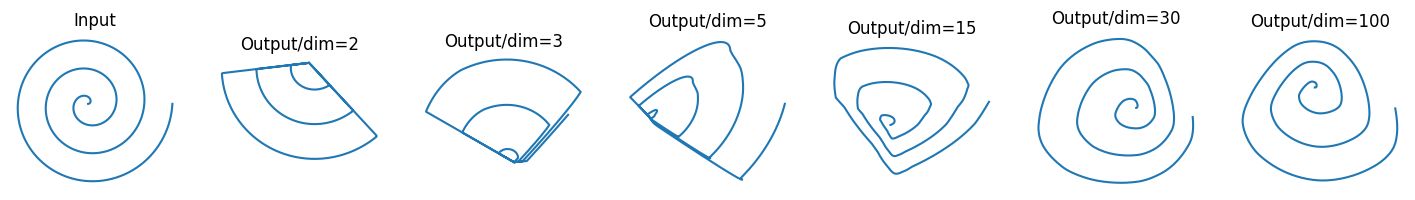

In [30]:
import matplotlib.pyplot as plt

# Dimensions to test
dims_to_test = [2, 3, 5, 15, 30, 100]

# Create a figure to hold all our plots
fig, axes = plt.subplots(1, len(dims_to_test) + 1, figsize=(18, 3))

# Plot the original input spiral
ax = axes[0]
ax.plot(input_spiral[:, 0], input_spiral[:, 1])
ax.set_title("Input")
ax.set_aspect('equal', 'box')
ax.axis('off')

# Loop through the dimensions, transform, and plot
for i, n in enumerate(dims_to_test):
    reconstructed_spiral = transform_manifold(input_spiral, n)
    
    ax = axes[i + 1]
    ax.plot(reconstructed_spiral[:, 0], reconstructed_spiral[:, 1])
    ax.set_title(f"Output/dim={n}")
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    
plt.show()

## The Moment of Truth: Analyzing Our Results

Let's break down what we're seeing here, moving from left to right.

### The Catastrophe: The Low-Dimension Case (`dim=2`, `dim=3`, `dim=5`)

First, look at the two plots immediately following the input. When we projected our 2D spiral into an equally low-dimensional space (2D or 3D) and applied `ReLU`, the result is a disaster.

The beautiful, continuous spiral is completely mangled.

This is exactly what the paper means by **catastrophic information loss**. The `ReLU` function, confined to a low-dimensional space, had no choice but to destroy large chunks of our manifold. You could never hope to reconstruct the original spiral from this wreckage.

### The Redemption: The High-Dimension Case (`dim=15`, `dim=30`, `dim=100`)

When we projected our spiral into a high-dimensional space (`dim=15`, `dim=30`, and especially `dim=100`) before applying `ReLU`, the structure of the spiral survived the round trip almost perfectly intact. All the loops are there, the spacing is correct, and the overall shape is instantly recognizable.

This is the **"high-dimensional safety net"** in action. By giving the manifold plenty of extra dimensions to exist in, we allowed `ReLU` to perform its non-linear transformation without destroying the essential information. Even if `ReLU` zeroed out a few of the dimensions, the core structure of the spiral was preserved in the many dimensions that remained.